In [10]:
from ffnavpy.satellite import Satellite, OBC

import ffnavpy.utils as utl
import numpy as np

from ffnavpy.simulator import Simulator, ChiefDeputyCase
from ffnavpy.satellite import CommandSequence

from ffnavpy.control_laws import ETM

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

%matplotlib inline




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# Initial state of deputy [km, km/s]

x0 = np.array(
    [
        1.50464846e08,
        0.00000000e00,
        1.85588146e06,
        -1.99045682e-15,
        -6.04730575e-02,
        -4.44642929e-14,
    ]
)

x0 = np.array([ 1.51287312e+08,  0.00000000e+00, -7.70118240e+04,  2.38772827e-14,
       -2.68181170e-01,  0.00000000e+00])

# Initial relative state [km, km/s]
dx0 = np.array([0.110, 0.09, 0.105, 1e-6, 0, 0])

# Initial state chief [km, km/s]
x0_cs = x0 + dx0

# State commanded
x_target = np.array([0.1, 0.1, 0.1, 0, 0, 0])

# Duration of the simulation [s]
tf = 1* 1.8*3600*1

# Time step of simulation [s]
dT = 1

# Create satellites with their corresponding initial states
LiteBird = Satellite(x0, 5, 5000)
CalSat = Satellite(x0_cs, 0.5, 7)

# OBC config
t_star = OBC.DefConfigOBC.ts
w0_slow = utl.compute_bandwidth_from_tau(300, t_star)
w0_fast = utl.compute_bandwidth_from_tau(300, t_star)
ConfigOBC = {'w0_estimation': w0_fast, 
             'w0_control': w0_slow,
             'x_target': x_target, 'estimation_mode': 'simple',
             'Tsk': 1,
             'control_mode': None,
             'sigma_r0': 1e-7,
             'sigma_v0': 1e-8,
             'sigma_x': 1e-4,
             'sigma_y': 1e-4,
             'sigma_z': 1e-4,
             'period': 24*3600}

configSim = {'sigma_distance': 1e-06, 'sigma_angle': 0.25}

cmd_sequence = CommandSequence()
cmd_sequence.add_command('change_control_mode', 'simple', 1000)
cmd_sequence.add_command('change_estimation_mode', 'kalman', 3000)
cmd_sequence.add_command('change_control_mode', 'LQR', 4800)
cmd_sequence.add_command('change_control_mode', 'ETM', 3600*2)

# Create predefined case for chief-deputy formation
simcase = ChiefDeputyCase(LiteBird, CalSat, cmd_sequence=cmd_sequence, configOBC=ConfigOBC)

# Create simulator with the defined case
sim = Simulator(simcase, dT, perturbations='SRP')


# Simulate
sim.simulate(tf)



0

In [12]:
plt.plot(sim.simcase.deputy.trajectory.time/60,sim.simcase.report.relative_state[:,0:3]*1e3)

plt.title('Relative position')
plt.xlabel('Time [min]')
plt.ylabel('Distance [m]')
plt.vlines([1000/60, 4800/60], 90, 115, colors='k', linestyles='dotted')
plt.hlines(100,sim.simcase.deputy.trajectory.time[0]/60, sim.simcase.deputy.trajectory.time[-1]/60, colors='k', linewidth=0.5)
plt.text(-3, 115, 'No control')
plt.text(42, 115, 'P control')
plt.text(95, 115, 'LQR')
plt.legend(['x', 'y', 'z'],loc=4)
plt.savefig('position')

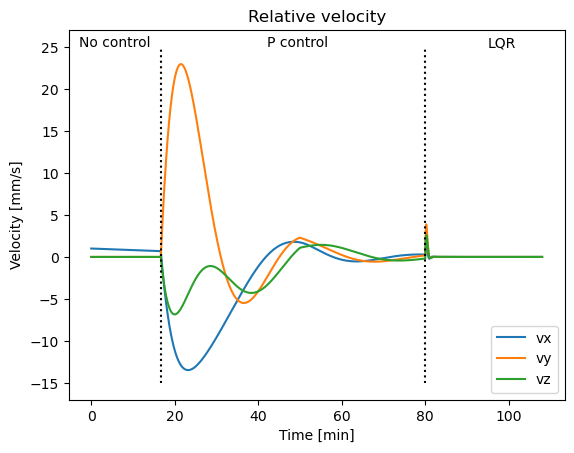

In [13]:
plt.plot(sim.simcase.deputy.trajectory.time/60, sim.simcase.report.relative_state[:,3:6]*1e6-x_target[3:]*1e6)
plt.title('Relative velocity')
plt.xlabel('Time [min]')
plt.ylabel('Velocity [mm/s]')
plt.vlines([1000/60, 4800/60], -15, 25, colors='k', linestyles='dotted')
plt.text(-3, 25, 'No control')
plt.text(42, 25, 'P control')
plt.text(95, 25, 'LQR')
plt.legend(['vx', 'vy', 'vz'], loc=4)
plt.savefig('velocity')

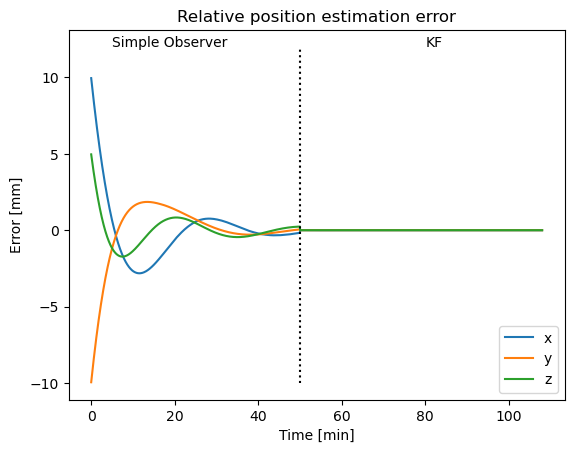

In [14]:
plt.plot(sim.simcase.deputy.trajectory.time/60, (sim.simcase.report.relative_state[:,0:3]-sim.simcase.report.x_estimated[:,0:3]) * 1e3)
plt.title('Relative position estimation error')
plt.ylabel('Error [mm]')
plt.xlabel('Time [min]')
plt.vlines([ 3000/60], -10, 12, colors='k', linestyles='dotted')
plt.text(5, 12, 'Simple Observer')
plt.text(80, 12, 'KF')
plt.legend(['x', 'y', 'z'], loc=4)
plt.savefig("error_r_est.png")

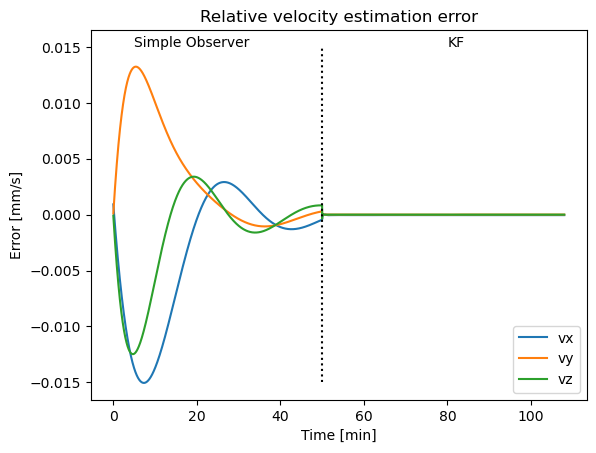

In [15]:
plt.plot(sim.simcase.deputy.trajectory.time/60, (sim.simcase.report.relative_state[:,3:6]-sim.simcase.report.x_estimated[:,3:6]) * 1e3)
plt.title('Relative velocity estimation error')
plt.ylabel('Error [mm/s]')
plt.xlabel('Time [min]')
plt.vlines([ 3000/60], -0.015, 0.015, colors='k', linestyles='dotted')
plt.text(5, 0.015, 'Simple Observer')
plt.text(80, 0.015, 'KF')
plt.legend(['vx', 'vy', 'vz'], loc=4)
plt.savefig("error_v_est.png")

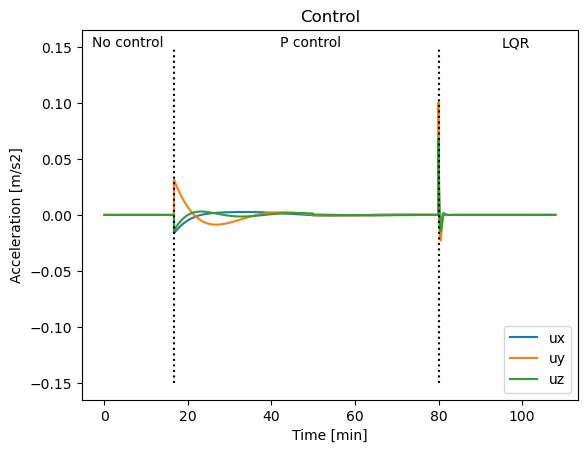

In [16]:
plt.plot(sim.simcase.deputy.trajectory.time/60,sim.simcase.report.u_cmd[:,:])
plt.title('Control')
plt.ylabel('Acceleration [m/s2]')
plt.xlabel('Time [min]')
plt.vlines([1000/60, 4800/60], -0.15, 0.15, colors='k', linestyles='dotted')
plt.text(-3, 0.15, 'No control')
plt.text(42, 0.15, 'P control')
plt.text(95, 0.15, 'LQR')
plt.legend(['ux', 'uy', 'uz'], loc=4)
plt.savefig("control.png")